In [162]:
import numpy as np
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor

In [163]:
from torch.utils.data import random_split

train_data = datasets.MNIST(
    root = 'data',
    train = True,
    transform = ToTensor(),
    download = True
)

generator = torch.Generator().manual_seed(42)
train_data, val_data = random_split(train_data, [50000, 10000], generator=generator)


test_data = datasets.MNIST(
    root = 'data',
    train = False,
    transform = ToTensor(),
    download = True
)

In [164]:
train_data
#train_data.data.shape
len(train_data)

50000

In [165]:
val_data
#val_data.data.shape
len(val_data)

10000

In [166]:
test_data
test_data.data.shape

torch.Size([10000, 28, 28])

In [167]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_data, batch_size=100, shuffle=True)
val_loader = DataLoader(val_data, batch_size=100, shuffle=False)
test_loader = DataLoader(test_data, batch_size=100, shuffle=False)

In [177]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


# images normally shaped as (batch_size, channels, height, width)

# MNIST (1, 28, 28) # since black & white -> 1 channel    rgb -> 3 channels

class MNIST_CNN(nn.Module):
    def __init__(self):
        super().__init__() # 784 (28x28)

        self.conv1 = nn.Conv2d(1, 16, kernel_size=(5,5), padding=2, padding_mode='zeros') 
        self.conv2 = nn.Conv2d(16, 32, kernel_size=(5,5), padding=2, padding_mode='zeros') 
        self.conv3 = nn.Conv2d(32, 64, kernel_size=(5,5), padding=2, padding_mode='zeros')
        self.fc1 = nn.Linear(64 * 7 * 7, 10)

        self.maxpool = nn.MaxPool2d(2) # reduces height and width by 2
        self.avgpool = nn.AvgPool2d(2)

        self.dropout = nn.Dropout2d(0.2)
        #self.batchnorm

    def forward(self, x):
        x = F.relu(self.conv1(x))

        x = F.relu(self.conv2(x))
        x = self.dropout(x)
        x = self.maxpool(x)
        
        x = F.relu(self.conv3(x))
        x = self.dropout(x)
        x = self.maxpool(x)
        
        # we want (batch_size, channels*height*width)
        x = torch.flatten(x, 1)        #x = x.view(x.size(0), -1)    flatten safer since doesnt need to be contiguous
        x = self.fc1(x)

        return x    # no softmax - cross entropy handles it internally
    


class MNIST_MLP(nn.Module):
    def __init__(self):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(64, 10)
        )

    def forward(self, x):
        # Reshape from (batch_size, 1, 28, 28) to (batch_size, 784)
        x = torch.flatten(x, 1)
        return self.layers(x)
    

In [178]:
#model = MNIST_CNN()
model = MNIST_MLP()

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [179]:
import os

model_dir = 'models'
os.makedirs(model_dir, exist_ok=True)

epochs = 20
best_correct = 0

for epoch in range(epochs):

    model.train()
    total_train_loss = 0.0
    train_total = 0
    train_correct = 0

    for x,y in train_loader:
        optimizer.zero_grad()

        # forward
        out = model(x)    # 10 probs for digits  (batch,10)
        loss = criterion(out, y)

        # backward
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

        with torch.no_grad():
            pred = out.argmax(dim=1) # index matches actual digit
            train_correct += (pred==y).sum().item()
            train_total += y.size(0)
    

    model.eval()
    total_val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for x, y in val_loader:
            out = model(x)
            loss = criterion(out, y)
            total_val_loss += loss.item()

            pred = out.argmax(dim=1)
            val_correct += (pred==y).sum().item()
            val_total += y.size(0) # how many in batch


    avg_train_loss = total_train_loss / len(train_loader)
    avg_val_loss = total_val_loss / len(val_loader)

    if val_correct > best_correct:
        best_correct = val_correct
        torch.save(model.state_dict(), os.path.join(model_dir, "best_mlp.pth"))

    if epoch % 1 == 0:
        print(f"Epoch: {epoch}   train loss: {avg_train_loss:.4f}    train acc: {train_correct/train_total * 100.0:.2f}%      val loss: {avg_val_loss:.4f}    val acc: {val_correct/val_total * 100.0:.2f}%")

Epoch: 0   train loss: 0.5105    train acc: 84.60%      val loss: 0.2293    val acc: 93.25%
Epoch: 1   train loss: 0.2255    train acc: 93.39%      val loss: 0.1633    val acc: 95.03%
Epoch: 2   train loss: 0.1696    train acc: 94.93%      val loss: 0.1328    val acc: 95.88%
Epoch: 3   train loss: 0.1353    train acc: 95.87%      val loss: 0.1092    val acc: 96.40%
Epoch: 4   train loss: 0.1138    train acc: 96.50%      val loss: 0.1053    val acc: 96.82%
Epoch: 5   train loss: 0.1024    train acc: 96.93%      val loss: 0.1031    val acc: 97.08%
Epoch: 6   train loss: 0.0881    train acc: 97.28%      val loss: 0.0904    val acc: 97.21%
Epoch: 7   train loss: 0.0809    train acc: 97.52%      val loss: 0.0901    val acc: 97.30%
Epoch: 8   train loss: 0.0767    train acc: 97.62%      val loss: 0.0910    val acc: 97.28%
Epoch: 9   train loss: 0.0687    train acc: 97.91%      val loss: 0.0833    val acc: 97.69%
Epoch: 10   train loss: 0.0640    train acc: 98.00%      val loss: 0.0873    val

In [180]:
#model = MNIST_CNN()
model = MNIST_MLP()
model.load_state_dict(torch.load(os.path.join(model_dir, "best_mlp.pth")))

correct = 0
total = 0

model.eval()
with torch.no_grad():
    for x,y in test_loader:
        out = model(x)

        pred = out.argmax(dim=1) # index matches actual digit
        correct += (pred==y).sum().item()
        total += y.size(0)

print(f"test correct: {correct}/{total}     test acc: {correct/total*100:.2f}%")

test correct: 9783/10000     test acc: 97.83%


torch.Size([1, 28, 28])
label: 4
torch.Size([1, 1, 28, 28])
torch.Size([1, 10])

pred: 4
actual: 4



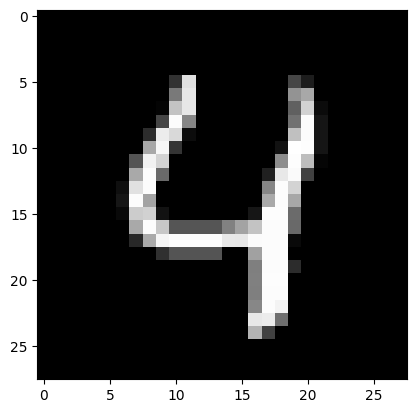

In [181]:
import matplotlib.pyplot as plt

# indvidual test
idx = 4
x, y = test_loader.dataset[idx]
#print("tensor:\n", x)
print(x.shape)
print("label:", y)

model.eval()
with torch.no_grad():
    x = x.unsqueeze(0)
    print(x.shape)

    out = model(x)      # 10 probs      (batch, )
    print(out.shape)
    pred = out.argmax(dim=1).item()

print(f"\npred: {pred}")
print(f"actual: {y}\n")

x = x.squeeze(0)
img = x.numpy().transpose(1,2,0)
plt.imshow(img, cmap='gray')
plt.show()